In [1]:
from selene_sdk.utils import load_path
from selene_sdk.utils import parse_configs_and_run

configs = load_path("deeper_deepsea_model.yml")

In [2]:
parse_configs_and_run(configs)

No top-level output directory specified. All constructors to be initialized (e.g. Sampler, TrainModel) that require this parameter must have it specified in their individual parameter configuration.


In [3]:
#Imports necessary for the visualization functions
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [4]:
from selene_sdk.predict import AnalyzeSequences
from selene_sdk.sequences import Genome
from selene_sdk.utils import load_features_list
from selene_sdk.utils import NonStrandSpecific
from selene_sdk.utils import DeeperDeepSEA

In [5]:
distinct_features = load_features_list("distinct_features.txt")

model_predict = AnalyzeSequences(
    NonStrandSpecific(DeepSEA(1000, 919)),
    "deeper_deepsea_model.pth.tar",
    sequence_length=1000,
    features=distinct_features,
    reference_sequence=Genome("hg38.fasta"),
    use_cuda=True  # update this to False if you do not have CUDA on your machine.
)

In [6]:
model_predict.variant_effect_prediction(
    "CHD_variants.vcf",
    save_data=["abs_diffs"],  # only want to save the absolute diff score data
    output_dir="./variants_output")

In [7]:
#Visualizing the absolute difference scores for variant effect prediction
from selene_sdk.interpret import load_variant_abs_diff_scores
from selene_sdk.interpret import variant_diffs_scatter_plot


dh_diffs, dh_labels, dh_features = load_variant_abs_diff_scores(
    os.path.join("variants_output", "CHD_variants_abs_diffs.tsv"))

In [8]:
fig = variant_diffs_scatter_plot(
    dh_diffs, dh_labels, dh_features,
    os.path.join("variants_output", "CHD_variantss.html"),  # output file path
    hg_reference_version="hg38",
    threshold_line=0.70,  # draws a horizontal line at `y=threshold_line`
    auto_open=False  # `auto_open=True` will open a new tab automatically with the HTML file.
)

In [10]:
model_predict.in_silico_mutagenesis_from_file(
    "regulatory_mutations.fa",
    save_data=["logits"],
    output_dir="./regulatory_mutations_output"
)

output_files = os.listdir("./regulatory_mutations_output")
print("Output filenames: {0}".format(output_files))

Output filenames: ['myo_infarc_LDL_CEBPB_T_to_G_mutation_logits.tsv', 'a_thalassemia_GATA1_T_to_C_mutation_logits.tsv']


In [11]:
#Visualizing the logit scores
import matplotlib.pyplot as plt
import numpy as np

from selene_sdk.interpret import heatmap
from selene_sdk.interpret import ISMResult

In [12]:
known_CEBPB_mutation = ISMResult.from_file(
    os.path.join("regulatory_mutations_output", "myo_infarc_LDL_CEBPB_T_to_G_mutation_logits.tsv"))

In [13]:
def _get_features_containing_str(feature_substring):
    features = []
    for feature in distinct_features:
        if feature_substring in feature:
            features.append(feature)
    return features

def _get_scores(ism_result, visualize_features, start, end):
    matrices = []
    for f in visualize_features:
        score_matrix = ism_result.get_score_matrix_for(f)
        matrices.append(score_matrix[start:end,])
    return matrices

def visualize(ism_result, target, start=400, end=600):
    """
    Parameters
    ----------
    ism_result : selene.interpret.ISMResult
        Output of `ISMResult.from_file` from an output file.
    target : str
        Pass in a feature name. If you want to visualize multiple features
        that share the same substring, pass in that substring.
    start : int
        Starting position for the heatmap visualization.
    end : int
        Ending position for the heatmap visualization.
    
    """
    target_features = _get_features_containing_str(target)
    matrices = _get_scores(ism_result, target_features, start, end)
    reference_encoding = Genome.sequence_to_encoding(
        ism_result.reference_sequence)[start:end,] == 1.
    for ix, m in enumerate(matrices):
        figure, (ax) = plt.subplots(1, 1, figsize=(24, 4))
        ax.patch.set(edgecolor="gray", hatch="//")
        ax.set_title("Feature {0}".format(target_features[ix]))
        
        # Set the min and max for the colorbar so that it is centered at 0.
        colorbar_bound = max(np.max(m), np.abs(np.min(m)))
        
        heatmap(m, mask=reference_encoding,
                cbar=True,
                cmap="bwr",
                vmin=-1 * colorbar_bound,
                vmax=colorbar_bound,
                ax=ax,
                linewidth=0.5,
                xticklabels=list(range(start, end)))

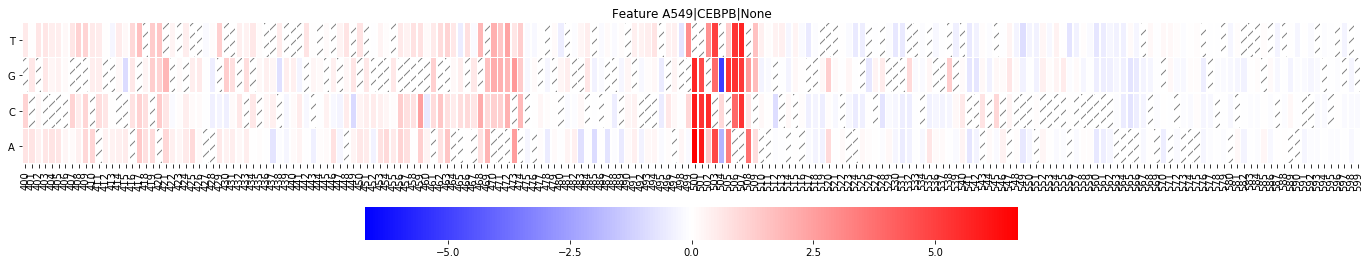

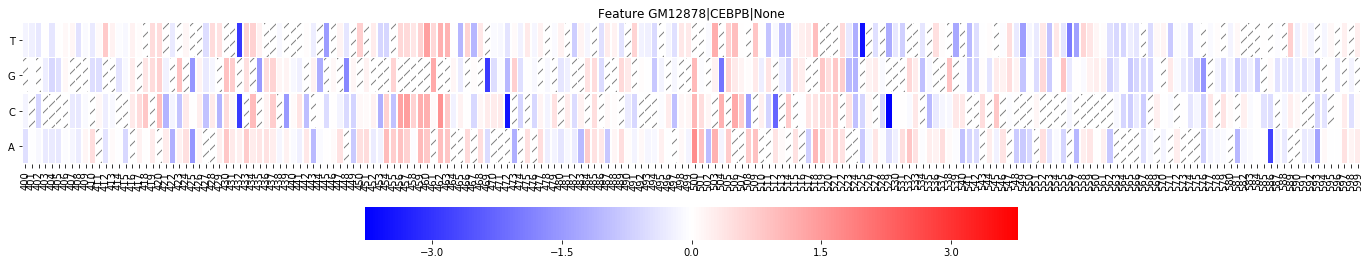

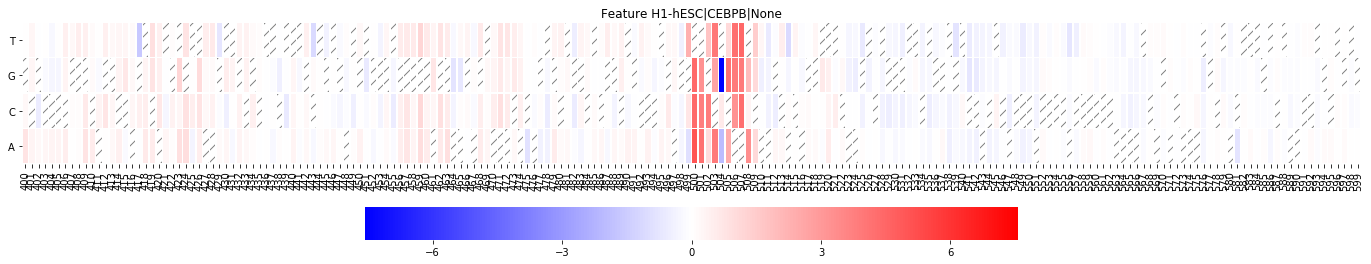

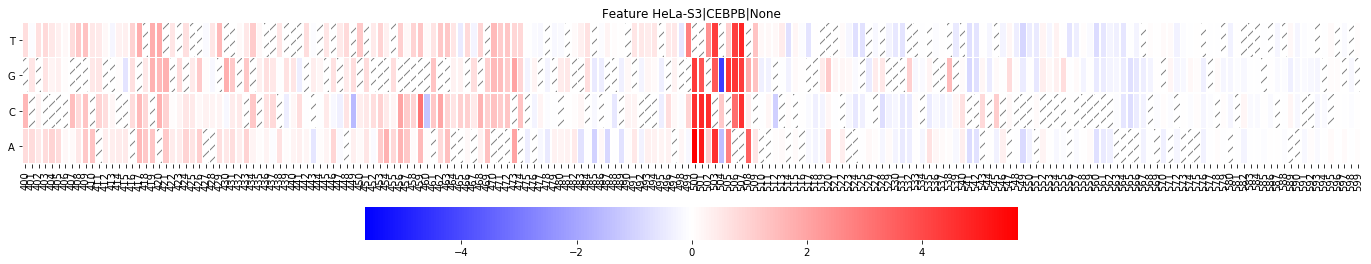

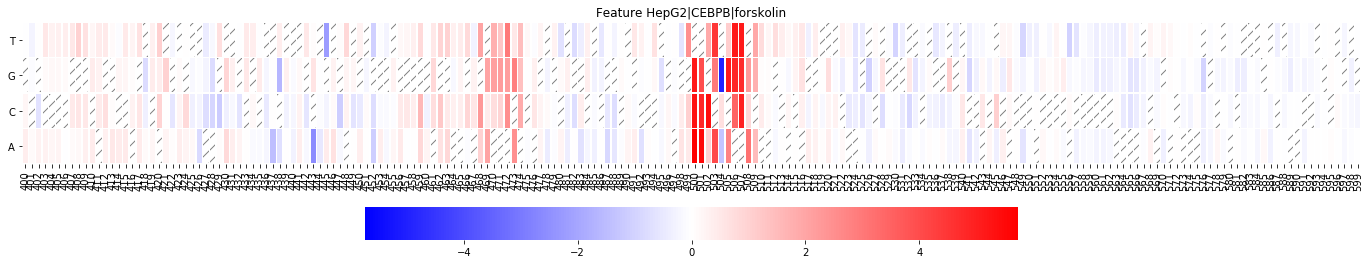

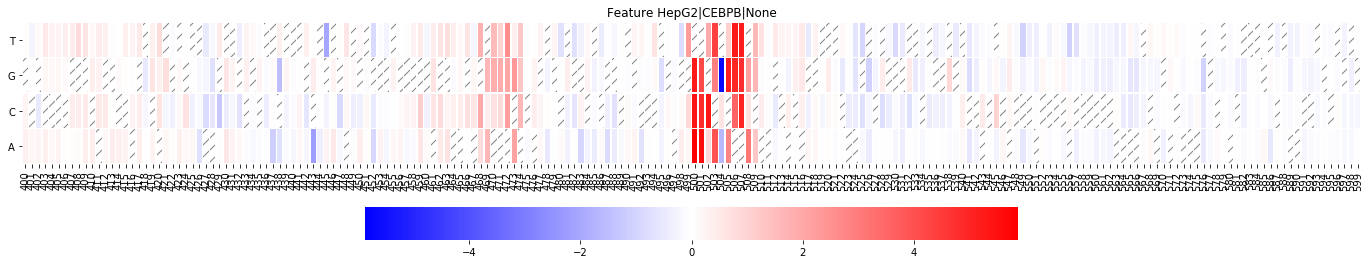

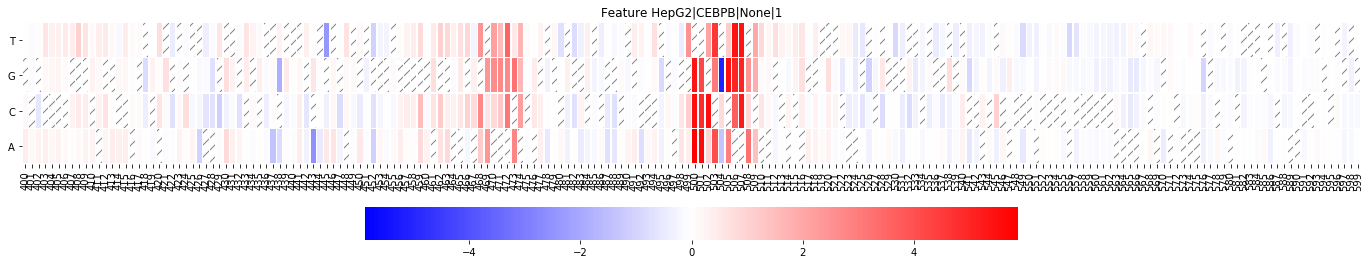

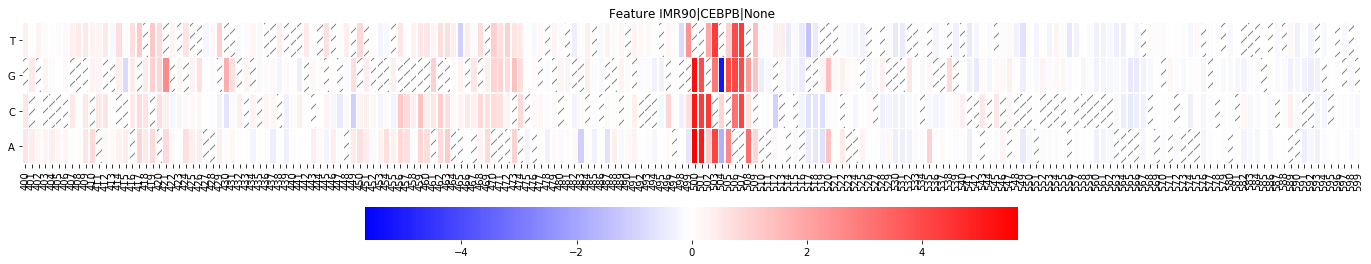

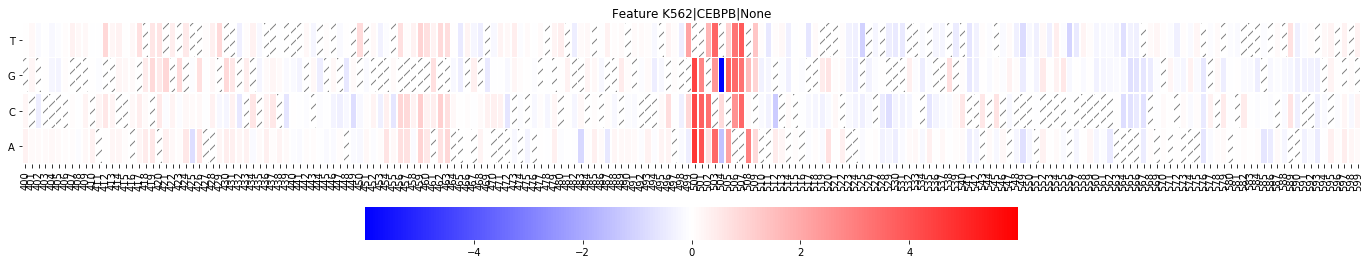

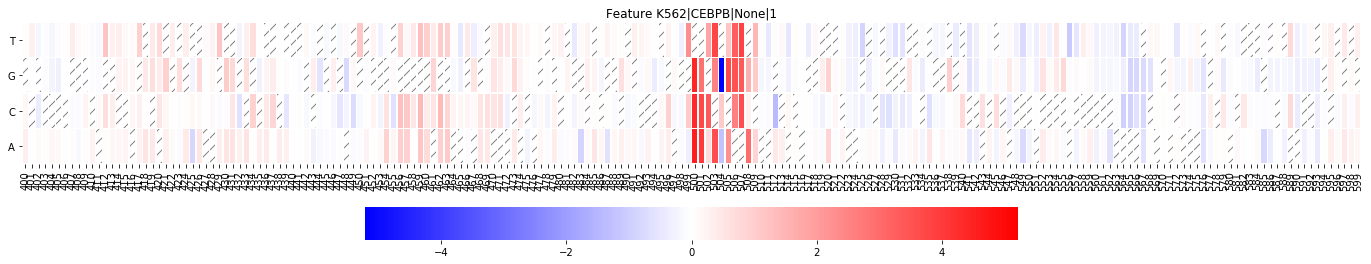

In [14]:
visualize(known_CEBPB_mutation, "CEBPB")

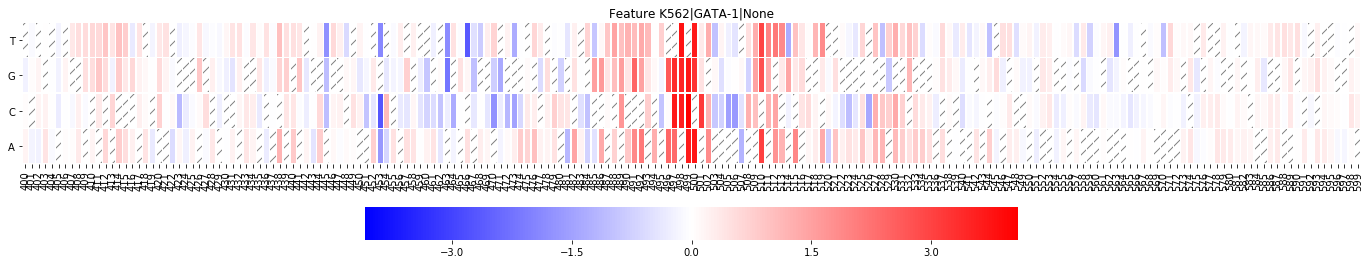

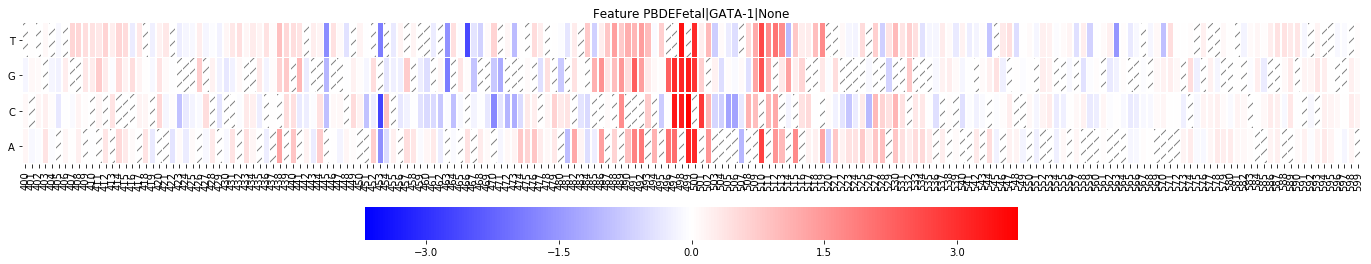

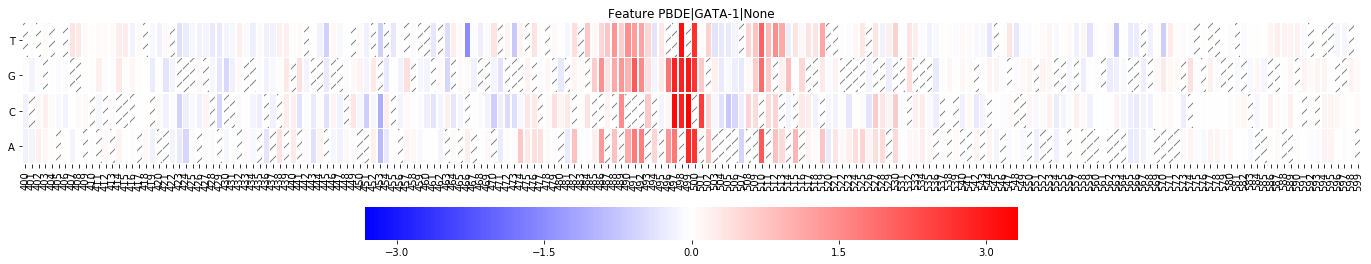

In [16]:
visualize(known_GATA1_mutation, "GATA-1")